In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Phrases,phrases
from gensim.models import Word2Vec
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from gensim.scripts import word2vec2tensor
from itertools import combinations

In [16]:
from sevenTimePeriods import period1,period2,period3,period4,period5, period6,period7
folder = '/srv/data/relevantEPBodySTOP'

def getTexts(folder,searchList):
    texts = []
    textnames = []
    for file in os.listdir(folder):
        name = file.split('.')[0]
        if '_' in name: name = name.split('_')[0]
        if name in searchList: 
            path = os.path.join(folder,file)
            f = open(path,'r')
            data = f.readlines()[0]
            texts.append(data)
            textnames.append(name)
            f.close()
    return texts,textnames


In [19]:
all_texts = getTexts(folder,period5)
tokenized = []
for text in all_texts[0]:
    words = []
    text = text.split(' ')
    for t in text:
        if len(t) != 0: words.append(t)
    tokenized.append(words)
print(len(tokenized))

1786


In [18]:
# Creared word2vec model and store it
word2vec = Word2Vec(tokenized, min_count=2,sg=1)
# word2vec.wv.save_word2vec_format('/srv/data/tensor/sermons.model')
word2vec.save('/srv/data/tensor/savedModels/period4.model')

In [ ]:
# Check similarity for a specific word
# 1635-1641
# print('Tobacco: ',word2vec.wv.most_similar("tobacco"))
# print('Drug:' ,word2vec.wv.most_similar("drug"))
# print('Luxury: ', word2vec.wv.most_similar("luxury"))
# print('Unwholesome: ', word2vec.wv.most_similar("unwholesome"))

#sermons 
# words = ['wine','beer','ale','sip','cup','liquor','drink','claret','draught']
# words = ['currans','tobacco','drug','virginia','turkey','eastindies']
words = ['plantation','idle','idleness','god','virginia','turk','muhammadan','muhammad','indian','catholic','popery','beast']
for term in words: 
    if term in word2vec.wv: print(term,': ', word2vec.wv.most_similar(term),'\n')


In [32]:
print(word2vec.wv.most_similar("addict"))
print(word2vec.wv.most_similar("trade"))

[('civility', 0.9583917260169983), ('degenerate', 0.9501819014549255), ('affectation', 0.9412734508514404), ('kind_life', 0.9377285838127136), ('unfit', 0.9373246431350708), ('singularity', 0.9345164895057678), ('maintainer', 0.9336016774177551), ('lucre', 0.932513952255249), ('ostentation', 0.9285672307014465), ('mechanical', 0.9281571507453918)]
[('traffic', 0.8311966061592102), ('merchant', 0.8234544992446899), ('commodity', 0.8171944618225098), ('commerce', 0.8131672739982605), ('east_india', 0.811136782169342), ('foreign', 0.8064207434654236), ('merchandise', 0.7984399795532227), ('beyond_sea', 0.7951279878616333), ('manufacture', 0.7951207160949707), ('east_indian', 0.792515218257904)]


In [30]:
#Create PCA table
pca = PCA(n_components=2)
pca_results = pca.fit_transform(word2vec.wv.get_normed_vectors())
pca_df = pd.DataFrame(pca_results, index=word2vec.wv.key_to_index, columns=["pc1","pc2"])


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

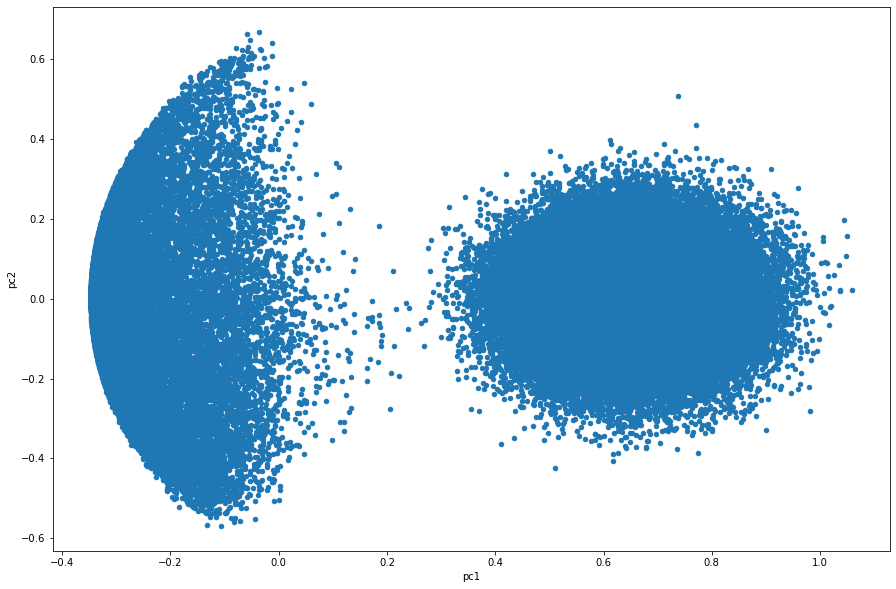

In [31]:
# Create PCA plots
pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10))

In [ ]:
# Create tsv file for word2vec model
word2vec2tensor.word2vec2tensor('/srv/data/tensor/relevantep.model', '/srv/data/tensor/TSV/relevantep', binary=False)

In [ ]:
# Scatter plot with label
ax = pca_df.plot(x='pc1',y='pc2',kind="scatter",figsize=(15, 10),alpha=0)
for txt in pca_df.index:
    if txt in ["tobacco", "unwholesome", "unhealthy", "addict"]:
        x = pca_df.pc1.loc[txt]
        y = pca_df.pc2.loc[txt]
        ax.annotate(txt, (x,y))
plt.show()

In [37]:
#Heatmap
vectors = word2vec.wv

def cosine_similarity(pair):

    '''
    Word2Vec.wv.similarity(word1,word2)
    '''
    word1, word2 = pair
    if word1 and word2 in vectors:
        sim = vectors.similarity(word1,word2)
        return sim
    return 0


def generate_heatmap_matrix(lexicon):

    pairs = list(combinations(lexicon, 2))
    sim_scores = [cosine_similarity(pair) for pair in pairs if cosine_similarity(pair) != 0]

    sim_df = pd.DataFrame({'pair': pairs, 'similarity': sim_scores})

    sim_df['word1'] = sim_df['pair'].apply(lambda x: lexicon.index(x[0]))
    sim_df['word2'] = sim_df['pair'].apply(lambda x: lexicon.index(x[1]))

    sim_df['pair'] = list(zip(sim_df.word1, sim_df.word2, sim_df.similarity))

    df_hm = pd.DataFrame({'word1': range(len(lexicon)),
                          'word2': range(len(lexicon)),
                          'similarity': pd.Series(np.ones(len(lexicon)))})

    df_hm = df_hm.pivot(index='word1', columns='word2').fillna(0)

    for row, col, similarity in sim_df.pair:

        df_hm.iloc[col,row] = similarity

    return df_hm


def plot_heatmap(lexicon,title):

    df_hm = generate_heatmap_matrix(lexicon)

    mask = np.zeros_like(df_hm)
    mask[np.triu_indices_from(mask)] = True
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_hm,
                mask = mask,
                xticklabels = lexicon,
                yticklabels = lexicon,
                cmap="YlGnBu",
                )
    plt.xlabel('word 1')
    plt.ylabel('word 2')
    plt.title(title)
    plt.show()


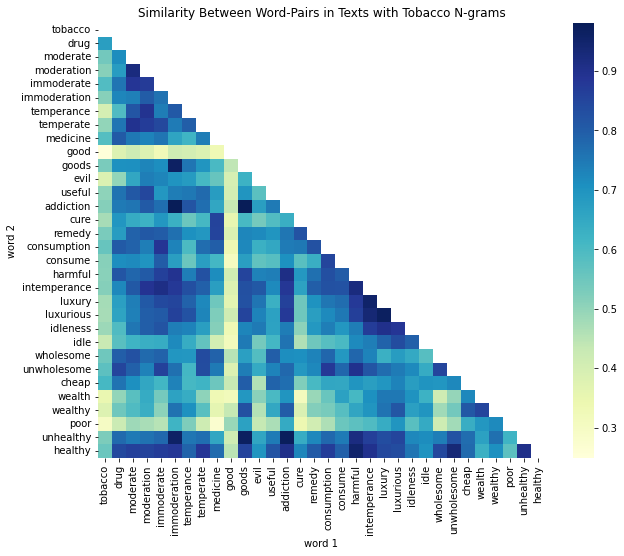

In [38]:
# lexicon = ['trade','power','evil','industry', 'savage', 'indian', 'spaniard', 'guyana', 'idleness']
# plot_heatmap(lexicon)
another = ['tobacco','drug','moderate','moderation','immoderate','immoderation','temperance',
            'temperate','medicine','good','goods','evil',
            'useful','addiction','cure','remedy','consumption','consume','harmful',
            'intemperance','luxury','luxurious','idleness','idle','wholesome','unwholesome','cheap','wealth',
            'wealthy','poor','unhealthy','healthy']
plot_heatmap(another,'Similarity Between Word-Pairs in Texts with Tobacco N-grams')